## Cumulant Expansion Method for Quantum Squeezing

The purpose of this notebook is to understand and practice using the packages and functions in final_seq_readout.ipynb. To do that we look at each piece of the hamiltonian sequence and add increasing complexity. First, we will completely solve for the state of a mode under a squeezing Hamiltonian. Then we will make it "time-dependent" by wrapping the Hamiltonian in an envelope; this way we will use certain animation functions. Then we will add in dissapation, and simulate again. Finally, I want to try at one point simulating the system under the full Hamiltonian of the system without any pulses.

We consider the squeezing of a single quantum resonator under the squeezing hamiltonian 
$$H_{sq} = - i r_a (e^{i \phi_a} \hat{a}^2 - e^{-i \phi_a} {\hat{a}^\dagger}^2) $$
with the bare cavity hamiltonian
$$H_0 = (\omega \pm \chi) \hat{a}^\dagger \hat{a} $$
(no pulses yet)

In [71]:
Base.active_project()

"/Users/emilylinden/Desktop/princeton/research/tureci/EA/embedded-amplifiers-control/Project.toml"

In [ ]:
using QuantumCumulants
using ModelingToolkit
using OrdinaryDiffEq
using Plots
using LinearAlgebra
using Random
using Distributions
using SpecialFunctions


In [2]:
h = FockSpace(:readout)
a = Destroy(h, :a)
@cnumbers r_a ϕ_a ω χ γa
H_0 = (χ) * a'*a # in rotating frame, omit ω
H_sq = -1im * r_a * (exp(1im * ϕ_a) * a^2 - exp(-1im * ϕ_a) * a'^2)
H = H_0 + H_sq

ops = [a, a', a'*a, a^2, a'^2] #ops = [a, a'*a]
# dissipators
J = [a]
γ = [γa];

Find EOM

In [3]:
# me = meanfield(ops, H, J; rates=γ, order=2)
me = meanfield(ops, H; order=2)
complete!(me)

∂ₜ(⟨a⟩) = (0 - 1im)*⟨a⟩*χ + (2 + 0im)r_a*⟨a′⟩*exp((0 - 1im)*ϕ_a)
∂ₜ(⟨a′⟩) = (0 + 1im)*⟨a′⟩*χ + (2 + 0im)r_a*⟨a⟩*exp((0 + 1im)*ϕ_a)
∂ₜ(⟨a′*a⟩) = (2 + 0im)r_a*exp((0 - 1im)*ϕ_a)*⟨a′*a′⟩ + (2 + 0im)r_a*exp((0 + 1im)*ϕ_a)*⟨a*a⟩
∂ₜ(⟨a*a⟩) = (2 + 0im)r_a*exp((0 - 1im)*ϕ_a) + (0 - 2im)*⟨a*a⟩*χ + (4 + 0im)r_a*⟨a′*a⟩*exp((0 - 1im)*ϕ_a)
∂ₜ(⟨a′*a′⟩) = (2 + 0im)r_a*exp((0 + 1im)*ϕ_a) + (0 + 2im)*⟨a′*a′⟩*χ + (4 + 0im)r_a*⟨a′*a⟩*exp((0 + 1im)*ϕ_a)


Can find these equations analytically (without dissipation) rather easily:

Now simulate:

In [6]:
@named sys = ODESystem(me)

# units 
ms = 1e3;
kHz = 1/ms;
μs = 1;
MHz = 1;
ns = 1e-3μs;
GHz = 1/ns;

# set paramters 
ps_e = [
    r_a => 1MHz,
    ϕ_a => 0.0,
    χ => -3MHz, # excited state 
    γa => 0.1MHz
]

ps_g = [
    r_a => 1MHz,
    ϕ_a => 0.0,
    χ => 3MHz, # ground state
    γa => 0.1MHz
]

t0 = 0.0
tF = 1.0
tspan = (t0, tF)
tlist = range(t0, tF, length=200)
u0 = zeros(ComplexF64, length(me));

In [ ]:
prob_e = ODEProblem(sys, u0, tspan, ps_e)
sol_e = solve(prob_e, Tsit5(); saveat=tlist, reltol=1e-10, abstol=1e-10)

prob_g = ODEProblem(sys, u0, tspan, ps_g)
sol_g = solve(prob_g, Tsit5(); saveat=tlist, reltol=1e-10, abstol=1e-10);

In [8]:
ENV["GKSwstype"] = "100"; # suppresses error

In [9]:
function mean_quadrature(u)
    a = u[1]
    ad = u[2]
    # <a> is u[1], so real and imag parts give X and Y means
    return [real(a), imag(a)]
end

function covariance_matrix(u)
    a, ad, ada, aa, adad = u
    Σxx = 1/2 .+ 1/2*( (aa .- a.*a) .+ 2(ada .- ad.*a) .+ (adad .- ad.*ad))
    Σxx = round(real.(Σxx), digits=10)

    Σyy = 1/2 .- 1/2*( (aa .- a.*a) .- 2(ada .- ad.*a) .+ (adad .- ad.*ad))
    Σyy = round(real.(Σyy), digits=10)

    Σxy = -1/2*1im*((aa .- a.*a) .- (adad .- ad.*ad))
    Σxy = round(real.(Σxy), digits=10)

    return [Σxx Σxy; Σxy Σyy]
end;

In [10]:
u_list_e = sol_e.u
X_mean_e = Float64[]
Y_mean_e = Float64[]
X_var_e = Float64[]
Y_var_e = Float64[]

for u in u_list_e
    a = u[1]
    M = covariance_matrix(u) # = [Σxx Σxy; Σxy Σyy]
    push!(X_var_e, M[1,1])   # Σxx
    push!(Y_var_e, M[2,2])   # Σyy
    push!(X_mean_e, real(a)) # 
    push!(Y_mean_e, imag(a)) # 
end 

u_list_g = sol_g.u
X_mean_g = Float64[]
Y_mean_g = Float64[]
X_var_g = Float64[]
Y_var_g = Float64[]

for u in u_list_g
    a = u[1]
    M = covariance_matrix(u) # = [Σxx Σxy; Σxy Σyy]
    push!(X_var_g, M[1,1])   # Σxx
    push!(Y_var_g, M[2,2])   # Σyy
    push!(X_mean_g, real(a)) # 
    push!(Y_mean_g, imag(a)) # 
end 

# plot(tlist, real.(sol[a^2]), label="Re(⟨a²⟩)")
# plot!(tlist, imag.(sol[a^2]), label="Im(⟨a²⟩)")
# plot!(tlist, real.(sol[a'^2]), label="Re(⟨a'²⟩)")
# plot!(tlist, imag.(sol[a'^2]), label="Im(⟨a'²⟩)")

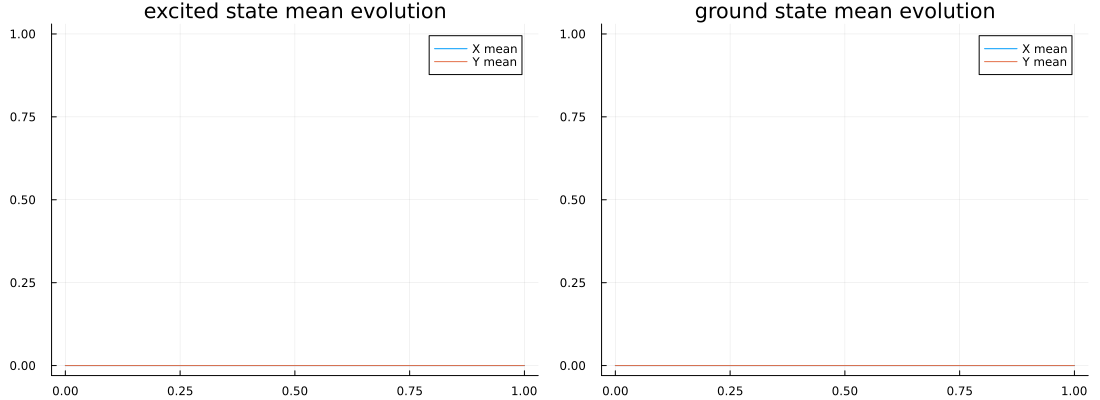

In [11]:
p1 = plot(tlist, X_mean_e, label="X mean", title="excited state mean evolution")
plot!(p1, tlist, Y_mean_e, label="Y mean")

p2 = plot(tlist, X_mean_g, label="X mean", title="ground state mean evolution")
plot!(p2, tlist, Y_mean_g, label="Y mean")

plot(p1, p2, layout = (1, 2), size = (1100, 400))

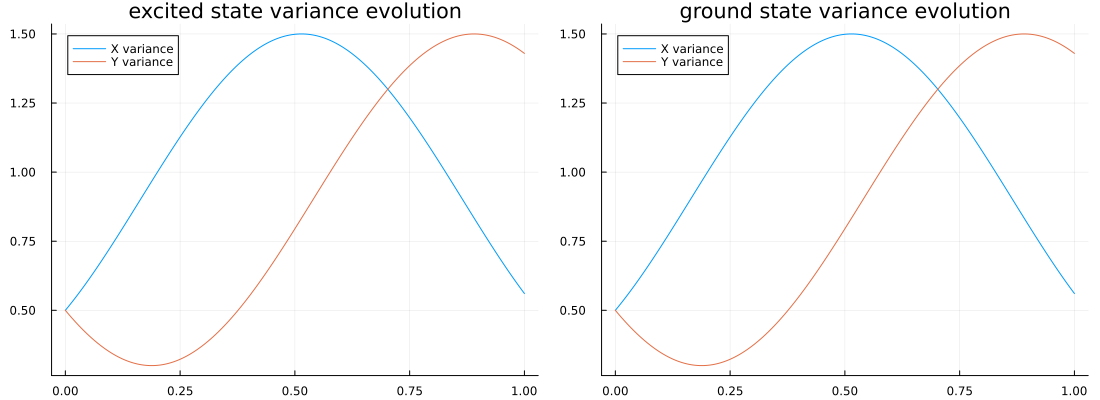

In [12]:
p1 = plot(tlist, X_var_e, label="X variance", title="excited state variance evolution")
plot!(p1, tlist, Y_var_e, label="Y variance")

p2 = plot(tlist, X_var_g, label="X variance", title="ground state variance evolution")
plot!(p2, tlist, Y_var_g, label="Y variance")

plot(p1, p2, layout = (1, 2), size = (1100, 400))

In [13]:
function plot_cov_ellipse!(μ, Σ; npoints=100, kwargs...)
    θ = range(0, 2π, length=npoints)  # angle parameter for ellipse
    vals, vecs = eigen(Σ)
    axes_lengths = sqrt.(vals)
    ellipse_points = [axes_lengths[1]*cos.(θ) axes_lengths[2]*sin.(θ)] * vecs'
    xs = ellipse_points[:, 1] .+ μ[1]
    ys = ellipse_points[:, 2] .+ μ[2]
    plot!(xs, ys; kwargs...)
end;

In [ ]:
# u_first = sol.u[1]
# u_last = sol.u[end]

# Σ_first = covariance_matrix(u_first)
# Σ_last = covariance_matrix(u_last)
# μ_first = mean_quadrature(u_first)
# μ_last = mean_quadrature(u_last);

# plot(size=(450, 450), legend=:topleft)
# plot_cov_ellipse!(μ_first, Σ_first, color=:blue, label="Start state")
# plot_cov_ellipse!(μ_last, Σ_last, color=:red, label="End state")
# scatter!([μ_first[1]], [μ_first[2]], markershape=:circle, color=:blue, label="Start mean")
# scatter!([μ_last[1]], [μ_last[2]], markershape=:circle, color=:red, label="End mean")
# xlabel!("X quadrature")
# ylabel!("Y quadrature")
# title!("Squeezing evolution in IQ plane")
# xlims!(-5, 5)
# ylims!(-5, 5)
# display(current());

[ Info: Saved animation to /Users/emilylinden/Desktop/princeton/research/tureci/EA/embedded-amplifiers-control/notebooks/parallel-model/emmy/IQ_readout_squeezing.gif


Plots.AnimatedGif("/Users/emilylinden/Desktop/princeton/research/tureci/EA/embedded-amplifiers-control/notebooks/parallel-model/emmy/IQ_readout_squeezing.gif")
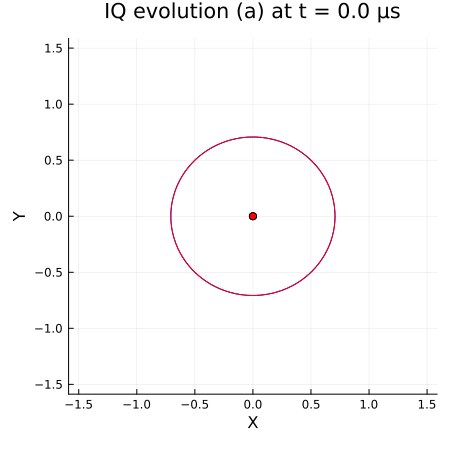

In [15]:
# get limits
uF = sol_e.u[end]
ΣF = covariance_matrix(uF)
μF = mean_quadrature(uF)
p_final = plot()
plot_cov_ellipse!(μF, ΣF)
lims = xlims(p_final)  # Use the x-axis limits from the final state

# animation loop
tspan_anim = LinRange(t0, tF, 100)
anim = @animate for t in tspan_anim
    u_e = sol_e(t)
    Σ_e = covariance_matrix(u_e)
    μ_e = mean_quadrature(u_e)

    u_g = sol_g(t)
    Σ_g = covariance_matrix(u_g)
    μ_g = mean_quadrature(u_g)
    
    p=plot(size=(450, 450), legend=:topleft)
    plot_cov_ellipse!(μ_e, Σ_e, color=:blue, label="excited state")
    plot_cov_ellipse!(μ_g, Σ_g, color=:red, label="ground state")
    scatter!([μ_e[1]], [μ_e[2]], markershape=:circle, color=:blue, legend=false)
    scatter!([μ_g[1]], [μ_g[2]], markershape=:circle, color=:red, legend=false)
    xlabel!("X")
    ylabel!("Y")
    title!("IQ evolution (a) at t = $(round(t, digits=3)) μs")
    xlims!(2 .*lims)
    ylims!(2 .*lims)
end

gif(anim, "IQ_readout_squeezing.gif", fps=20)

In [16]:
tspan_anim = LinRange(t0, tF, 100)
angles_e = zeros(length(tspan_anim))
angles_g = zeros(length(tspan_anim))

for (i, t) in enumerate(tspan_anim)
    u_e = sol_e(t)
    Σ_e = covariance_matrix(u_e)
    vals, vecs = eigen(Σ_e)
    idx = argmax(vals)
    major_vec = vecs[:, idx]
    angles_e[i] = mod(atan(major_vec[2], major_vec[1]), 2π)

    u_g = sol_g(t)
    Σ_g = covariance_matrix(u_g)
    vals, vecs = eigen(Σ_g)
    idx = argmax(vals)
    major_vec = vecs[:, idx]
    angles_g[i] = mod(atan(major_vec[2], major_vec[1]), 2π)
end

angle_diff = angles_e .- angles_g;
# angle_diff = mod.(angle_diff, 2π);

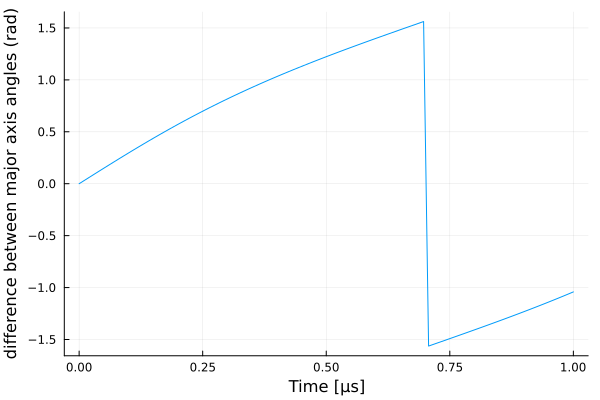

In [17]:
plot(tspan_anim, angle_diff, legend=false)
xlabel!("Time [μs]")
ylabel!("difference between major axis angles (rad)")

The jump happens to be right at the place we're interested in--where the ellipses are an angle of pi/2 apart. This happens at t=~0.7μs.

In [18]:
idx = argmin(abs.(angle_diff .- π/2))
t_ortho = tspan_anim[idx]

println("Excited and ground covariance ellipses are orthogonal at t ≈ ", t_ortho," μs")

Excited and ground covariance ellipses are orthogonal at t ≈ 0.696969696969697 μs


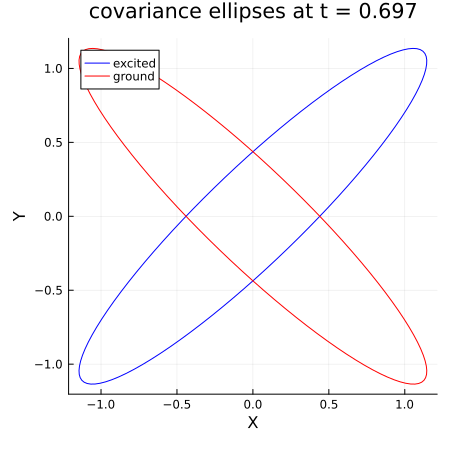

In [20]:
p_ortho = plot(size=(450,450), legend=:topleft)

# excited state
u_ortho_e = sol_e(t_ortho)
Σ_ortho_e = covariance_matrix(u_ortho_e)
μ_ortho_e = mean_quadrature(u_ortho_e)
plot_cov_ellipse!(μ_ortho_e, Σ_ortho_e, color=:blue, label="excited")

# ground state
u_ortho_g = sol_g(t_ortho)
Σ_ortho_g = covariance_matrix(u_ortho_g)
μ_ortho_g = mean_quadrature(u_ortho_g)
plot_cov_ellipse!(μ_ortho_g, Σ_ortho_g, color=:red, label="ground")

xlabel!("X")
ylabel!("Y")
title!("covariance ellipses at t = $(round(t_ortho, digits=3))")

Metrics to look into: mahalanobis mean separation, relative squeezing anisotropy (product of eccentricities), differential squeezing angle.

How to take measurement samples without stochastic truncated EOM?


In [ ]:
# calculate misclassification error for two classes

struct GaussianState
    μ::Vector{Float64}      # mean vector (length 2)
    Σ::Matrix{Float64}      # covariance matrix (2×2)
end

# Monte Carlo Bayes error
function bayes_error(g1::GaussianState,
                     g2::GaussianState;
                     N::Int = 200_000,
                     seed::Int = 0)

    # check for equal covariances
    if g1.Σ ≈ g2.Σ
        # closed-form formula
        Δμ = g2.μ - g1.μ
        Σinv = inv(g1.Σ)
        D2 = (Δμ' * Σinv * Δμ)[1]
        return 0.5 * erfc(sqrt(D2) / (2*sqrt(2)))
    end

    # Monte Carlo fallback
    rng = MersenneTwister(seed)

    d1 = MvNormal(g1.μ, g1.Σ)
    d2 = MvNormal(g2.μ, g2.Σ)

    err = 0
    for _ in 1:(N ÷ 2)
        x1 = rand(rng, d1)
        x2 = rand(rng, d2)

        # classify: true → g2, false → g1
        if logpdf(d2, x1) > logpdf(d1, x1)  # g1 misclassified
            err += 1
        end
        if logpdf(d1, x2) > logpdf(d2, x2)  # g2 misclassified
            err += 1
        end
    end

    return err / N
end;

In [25]:
g_e = GaussianState(μ_ortho_e, Σ_ortho_e)
g_g = GaussianState(μ_ortho_g, Σ_ortho_g)

Perr = bayes_error(g_e, g_g, N=100_000)
println("Bayes misclassification probability: ", Perr)

Bayes misclassification probability: 0.12641


In [34]:
function sanitize_covariance(Σ; ϵ=1e-10)
    Σr = real.(Σ)
    Σs = 0.5 * (Σr + Σr')
    vals = eigvals(Σs)
    λmin = minimum(vals)
    if λmin < ϵ
        Σs += (ϵ - λmin) * I
    end
    return Σs
end;

In [45]:
# sweep strength r
function logrange(a, b, length) 
    return exp.(range(log(a), log(b), length=length))
end
rs = [0.001MHz, 0.01MHz, 0.1MHz, 1MHz, 10MHz, 100MHz]

mprobs = zeros(length(rs))
t_orthos = zeros(length(rs))
for (i,r) in enumerate(rs)
    # set up two problems and solve
    ps_e = [
        r_a => r,
        ϕ_a => 0.0,
        χ => -3MHz, # excited state 
        γa => 0.1MHz
    ]

    ps_g = [
        r_a => r,
        ϕ_a => 0.0,
        χ => 3MHz, # ground state
        γa => 0.1MHz
    ]

    t0 = 0.0
    tF = 1.0
    tspan = (t0, tF)
    tlist = range(t0, tF, length=200)
    u0 = zeros(ComplexF64, length(me))

    prob_e = ODEProblem(sys, u0, tspan, ps_e)
    sol_e = solve(prob_e, Tsit5(); saveat=tlist, reltol=1e-10, abstol=1e-10)

    prob_g = ODEProblem(sys, u0, tspan, ps_g)
    sol_g = solve(prob_g, Tsit5(); saveat=tlist, reltol=1e-10, abstol=1e-10)

    # find time when states are orthogonal
    angles_e = zeros(length(tlist))
    angles_g = zeros(length(tlist))

    for (j, t) in enumerate(tlist)
        u_e = sol_e(t)
        Σ_e = covariance_matrix(u_e)
        vals, vecs = eigen(Σ_e)
        idx = argmax(vals)
        major_vec = vecs[:, idx]
        angles_e[j] = mod(atan(major_vec[2], major_vec[1]), 2π)

        u_g = sol_g(t)
        Σ_g = covariance_matrix(u_g)
        vals, vecs = eigen(Σ_g)
        idx = argmax(vals)
        major_vec = vecs[:, idx]
        angles_g[j] = mod(atan(major_vec[2], major_vec[1]), 2π)
    end

    angle_diff = angles_e .- angles_g
    idx = argmin(abs.(angle_diff .- π/2))
    t_ortho = tlist[idx]
    t_orthos[i] = t_ortho

    # find orthogonal gaussians
    u_ortho_e = sol_e(t_ortho)
    Σ_ortho_e = sanitize_covariance(covariance_matrix(u_ortho_e))
    μ_ortho_e = mean_quadrature(u_ortho_e)
    g_e = GaussianState(μ_ortho_e, Σ_ortho_e)

    u_ortho_g = sol_g(t_ortho)
    Σ_ortho_g = sanitize_covariance(covariance_matrix(u_ortho_g))
    μ_ortho_g = mean_quadrature(u_ortho_g)
    g_g = GaussianState(μ_ortho_g, Σ_ortho_g)

    # finally calculate misclassification probability
    Perr = bayes_error(g_e, g_g, N=100_000)
    mprobs[i] = Perr
end


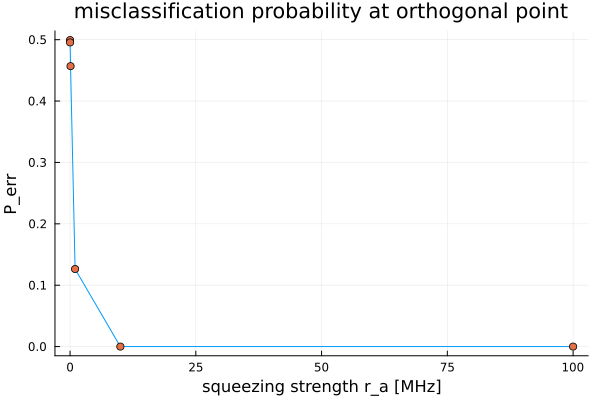

In [52]:
# plot miscalculation probability
plot(rs, mprobs, legend=false)
scatter!(rs, mprobs, legend=false)
xlabel!("squeezing strength r_a [MHz]")
ylabel!("P_err")
title!("misclassification probability at orthogonal point")

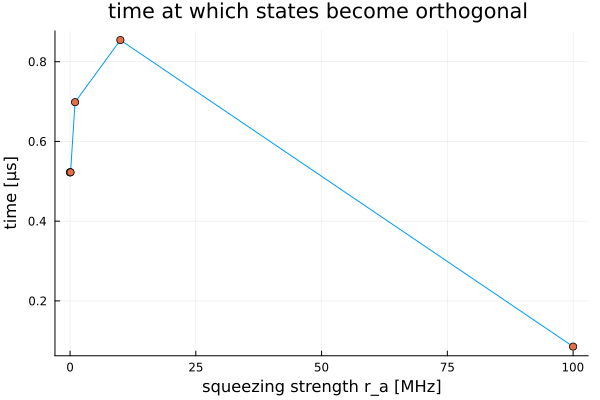

In [68]:
# out of curiousity plot times at which states become orthogonal
plot(rs, t_orthos, legend=false)
scatter!(rs, t_orthos, legend=false)
xlabel!("squeezing strength r_a [MHz]")
ylabel!("time [μs]")
title!("time at which states become orthogonal ")

^This plot will have a period; picture is incomplete without more points. Why is the rotation rate dependent on r?

## Driving hamiltonian piece

Looking at driving hamiltonian now:
    $$
        \hat{H}_{2} = |\eta_d| \left(e^{i(\omega_d - \omega_a) t} \hat{a} + e^{-i(\omega_d - \omega_a) t} \hat{a}^\dagger  \right)  = η_d \left( \hat{a} + \hat{a}^\dagger \right) 
    $$

In [54]:
h = FockSpace(:readout)
a = Destroy(h, :a)
@cnumbers η_d χ γa
H_0 = (χ) * a'*a # in rotating frame, omit ω
H_d = η_d * (a+ a')
H = H_0 + H_d

ops = [a, a', a'*a, a^2, a'^2] #ops = [a, a'*a]
# dissipators
J = [a]
γ = [γa];
# me = meanfield(ops, H, J; rates=γ, order=2)
me = meanfield(ops, H; order=2) # no dissipation
complete!(me)

∂ₜ(⟨a⟩) = (0 - 1im)*η_d + (0 - 1im)*⟨a⟩*χ
∂ₜ(⟨a′⟩) = (0 + 1im)*η_d + (0 + 1im)*⟨a′⟩*χ
∂ₜ(⟨a′*a⟩) = (0 - 1im)*⟨a′⟩*η_d + (0 + 1im)*⟨a⟩*η_d
∂ₜ(⟨a*a⟩) = (0 - 2im)*⟨a⟩*η_d + (0 - 2im)*⟨a*a⟩*χ
∂ₜ(⟨a′*a′⟩) = (0 + 2im)*⟨a′⟩*η_d + (0 + 2im)*⟨a′*a′⟩*χ


In [55]:
@named sys = ODESystem(me)

# units 
ms = 1e3;
kHz = 1/ms;
μs = 1;
MHz = 1;
ns = 1e-3μs;
GHz = 1/ns;

# set paramters 
ps_e = [
    η_d => 1MHz,
    χ => -3MHz, # excited state 
    γa => 0.1MHz
]

ps_g = [
    η_d => 1MHz,
    χ => 3MHz, # ground state
    γa => 0.1MHz
]

t0 = 0.0
tF = 1.0
tlist = range(t0, tF, length=200)
u0 = zeros(ComplexF64, length(me));

In [56]:
prob_e = ODEProblem(sys, u0, tspan, ps_e)
sol_e = solve(prob_e, Tsit5(); saveat=tlist, reltol=1e-10, abstol=1e-10)

prob_g = ODEProblem(sys, u0, tspan, ps_g)
sol_g = solve(prob_g, Tsit5(); saveat=tlist, reltol=1e-10, abstol=1e-10);

In [57]:
u_list_e = sol_e.u
X_mean_e = Float64[]
Y_mean_e = Float64[]
X_var_e = Float64[]
Y_var_e = Float64[]

for u in u_list_e
    a = u[1]
    M = covariance_matrix(u) # = [Σxx Σxy; Σxy Σyy]
    push!(X_var_e, M[1,1])   # Σxx
    push!(Y_var_e, M[2,2])   # Σyy
    push!(X_mean_e, real(a)) # 
    push!(Y_mean_e, imag(a)) # 
end 

u_list_g = sol_g.u
X_mean_g = Float64[]
Y_mean_g = Float64[]
X_var_g = Float64[]
Y_var_g = Float64[]

for u in u_list_g
    a = u[1]
    M = covariance_matrix(u) # = [Σxx Σxy; Σxy Σyy]
    push!(X_var_g, M[1,1])   # Σxx
    push!(Y_var_g, M[2,2])   # Σyy
    push!(X_mean_g, real(a)) # 
    push!(Y_mean_g, imag(a)) # 
end 

# plot(tlist, real.(sol[a^2]), label="Re(⟨a²⟩)")
# plot!(tlist, imag.(sol[a^2]), label="Im(⟨a²⟩)")
# plot!(tlist, real.(sol[a'^2]), label="Re(⟨a'²⟩)")
# plot!(tlist, imag.(sol[a'^2]), label="Im(⟨a'²⟩)")

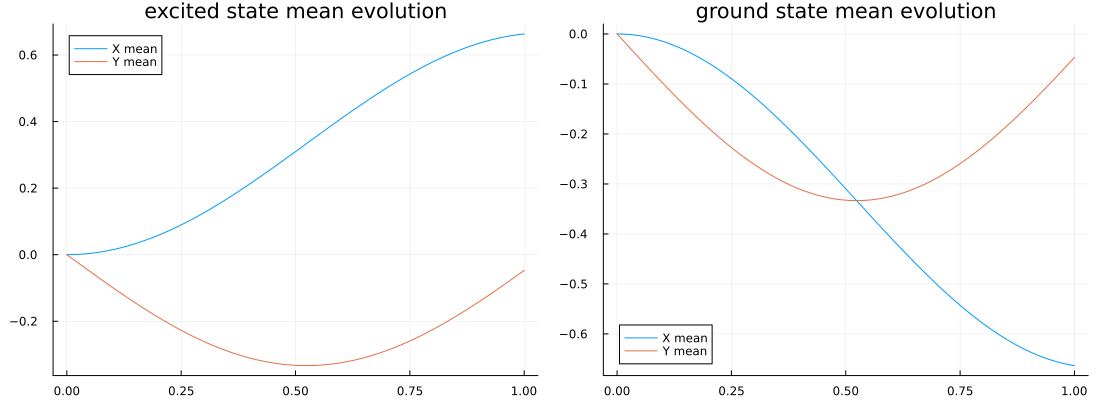

In [58]:
p1 = plot(tlist, X_mean_e, label="X mean", title="excited state mean evolution")
plot!(p1, tlist, Y_mean_e, label="Y mean")

p2 = plot(tlist, X_mean_g, label="X mean", title="ground state mean evolution")
plot!(p2, tlist, Y_mean_g, label="Y mean")

plot(p1, p2, layout = (1, 2), size = (1100, 400))

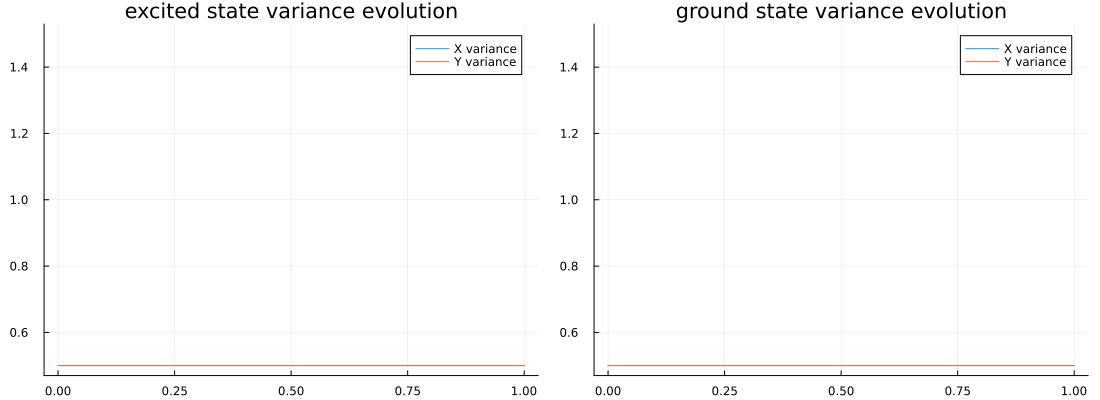

In [59]:
p1 = plot(tlist, X_var_e, label="X variance", title="excited state variance evolution")
plot!(p1, tlist, Y_var_e, label="Y variance")

p2 = plot(tlist, X_var_g, label="X variance", title="ground state variance evolution")
plot!(p2, tlist, Y_var_g, label="Y variance")

plot(p1, p2, layout = (1, 2), size = (1100, 400))

[ Info: Saved animation to /Users/emilylinden/Desktop/princeton/research/tureci/EA/embedded-amplifiers-control/notebooks/parallel-model/emmy/IQ_readout_drive.gif


Plots.AnimatedGif("/Users/emilylinden/Desktop/princeton/research/tureci/EA/embedded-amplifiers-control/notebooks/parallel-model/emmy/IQ_readout_drive.gif")
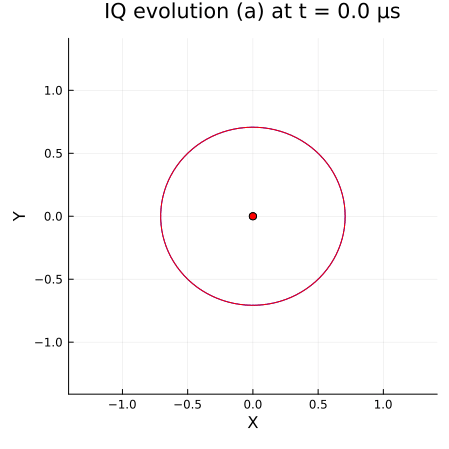

In [67]:
# get limits
uF = sol_e.u[end]
ΣF = covariance_matrix(uF)
μF = mean_quadrature(uF)
p_final_e = plot()
plot_cov_ellipse!(μF, ΣF)
uF = sol_g.u[end]
ΣF = covariance_matrix(uF)
μF = mean_quadrature(uF)
p_final_g = plot()
plot_cov_ellipse!(μF, ΣF)
lim = maximum(abs.(collect(Iterators.flatten((xlims(p_final_e),xlims(p_final_g))))))
# animation loop
tspan_anim = LinRange(t0, tF, 100)
anim = @animate for t in tspan_anim
    u_e = sol_e(t)
    Σ_e = covariance_matrix(u_e)
    μ_e = mean_quadrature(u_e)

    u_g = sol_g(t)
    Σ_g = covariance_matrix(u_g)
    μ_g = mean_quadrature(u_g)
    
    p=plot(size=(450, 450), legend=:topleft)
    plot_cov_ellipse!(μ_e, Σ_e, color=:blue, label="excited state")
    plot_cov_ellipse!(μ_g, Σ_g, color=:red, label="ground state")
    scatter!([μ_e[1]], [μ_e[2]], markershape=:circle, color=:blue, legend=false)
    scatter!([μ_g[1]], [μ_g[2]], markershape=:circle, color=:red, legend=false)
    xlabel!("X")
    ylabel!("Y")
    title!("IQ evolution (a) at t = $(round(t, digits=3)) μs")
    xlims!((-lim, lim))
    ylims!((-lim, lim))
end

gif(anim, "IQ_readout_drive.gif", fps=20)

Want to calculate misclassification error here but need basis for 'fair comparison'

In [21]:
# plot()
# plot_cov_ellipse(μ_first, Σ_first, color=:blue, label="Start state")
# # plot_cov_ellipse(μ_last, Σ_last, color=:red, label="End state")
# scatter!([μ_first[1], μ_last[1]], [μ_first[2], μ_last[2]], markershape=:circle, color=[:blue :red], label="Mean")
# xlabel!("X quadrature")
# ylabel!("Y quadrature")

# plot()
# # plot_cov_ellipse(μ_first, Σ_first, color=:blue, label="Start state")
# plot_cov_ellipse(μ_last, Σ_last, color=:red, label="End state")
# scatter!([μ_first[1], μ_last[1]], [μ_first[2], μ_last[2]], markershape=:circle, color=[:blue :red], label="Mean")
# xlabel!("X quadrature")
# ylabel!("Y quadrature")
# title!("Squeezing evolution in IQ plane")
# xlims!(-5, 5)
# ylims!(-5, 5)
# display(current());

Now wrap Hamiltonian H in an envelope to obtain H'. Simulate everything again.

In [17]:
using SpecialFunctions

In [18]:
# new time parameters
@cnumbers T0 T

h_ = FockSpace(:readout)
o = Destroy(h_, :o)
@cnumbers r_o ϕ_o

@syms t::Real 
@register f_0(t, T0::typeof(T0), Td::typeof(T))    #  squeezing

# define new time dependent Hamiltonian (old Hamiltonian but now in envelope)
H_old = -1im * r_o * (exp(1im * ϕ_o) * o^2 - exp(-1im * ϕ_o) * o'^2)
H_ = f_0(t, T0, T)*H_old

((0 - 1im)*r_o*f_0(t, T0, T)*exp((0 + 1im)*ϕ_o)*(o*o)+(0 + 1im)*r_o*exp((0 - 1im)*ϕ_o)*f_0(t, T0, T)*(o′*o′))

In [19]:
ops_ = [o, o', o'*o, o^2, o'^2] #ops = [a, a'*a]
me_ = meanfield(ops_, H_; order=2)
complete!(me_)

∂ₜ(⟨o⟩) = (2 + 0im)r_o*exp((0 - 1im)*ϕ_o)*f_0(t, T0, T)*⟨o′⟩
∂ₜ(⟨o′⟩) = (2 + 0im)r_o*f_0(t, T0, T)*exp((0 + 1im)*ϕ_o)*⟨o⟩
∂ₜ(⟨o′*o⟩) = (2 + 0im)r_o*exp((0 - 1im)*ϕ_o)*f_0(t, T0, T)*⟨o′*o′⟩ + (2 + 0im)r_o*f_0(t, T0, T)*exp((0 + 1im)*ϕ_o)*⟨o*o⟩
∂ₜ(⟨o*o⟩) = (2 + 0im)r_o*exp((0 - 1im)*ϕ_o)*f_0(t, T0, T) + (4 + 0im)r_o*exp((0 - 1im)*ϕ_o)*⟨o′*o⟩*f_0(t, T0, T)
∂ₜ(⟨o′*o′⟩) = (2 + 0im)r_o*f_0(t, T0, T)*exp((0 + 1im)*ϕ_o) + (4 + 0im)r_o*⟨o′*o⟩*f_0(t, T0, T)*exp((0 + 1im)*ϕ_o)


In [20]:
# Time units
ms = 1e3;
kHz = 1/ms;

μs = 1;
MHz = 1;

ns = 1e-3μs;
GHz = 1/ns;

# Pulse shape definition
gaussian_pulse(t; a=1, v1=1, v2=1, t1=2, t2=10, δ=0, ϕ=0) =  a/4*exp(-im*(ϕ + (t-t1)*δ))*erfc(-v1*(t-t1))*erfc(v2*(t-t2))

# Timing parameters
T0_ = 50ns                                    # sequence start
delay = 50ns                                  # delay between pulses

T0a_, Ta_   = T0_, 50ns                       # readout squeezing timings

# Pulse shapes using the correct parameters
f0_(t, T0, T)   = real(gaussian_pulse(t; a=1, v1=500MHz, v2=500MHz, t1=T0,   t2=T0 + T,   δ=0, ϕ=0))

# Insert the pulse shape functions explicitly
f_0(t, T0, T)   = f0_(t, T0, T)

f_0 (generic function with 12 methods)

In [21]:
@named sys_ = ODESystem(me_)
ps_ = [
    r_o => 0.1,
    ϕ_o => 0.0,
    T0 => T0a_, 
    T => Ta_
]
tspan = (0.0, 2.0)  # arbitrary units, adjust as needed
tlist = range(tspan[1], tspan[2], length=200)
u0 = zeros(ComplexF64, length(me))

prob_ = ODEProblem(sys_, u0, tspan, ps_)
sol_ = solve(prob_, Tsit5(); saveat=tlist, reltol=1e-10, abstol=1e-10);

In [22]:
u_list_ = sol_.u
X_mean_ = Float64[]
Y_mean_ = Float64[]
X_var_ = Float64[]
Y_var_ = Float64[]

for u in u_list_
    o = u[1]
    M = covariance_matrix(u) # = [Σxx Σxy; Σxy Σyy]
    push!(X_var_, M[1,1])   # Σxx
    push!(Y_var_, M[2,2])   # Σyy
    push!(X_mean_, real(o)) # 
    push!(Y_mean_, imag(o)) # 
end 

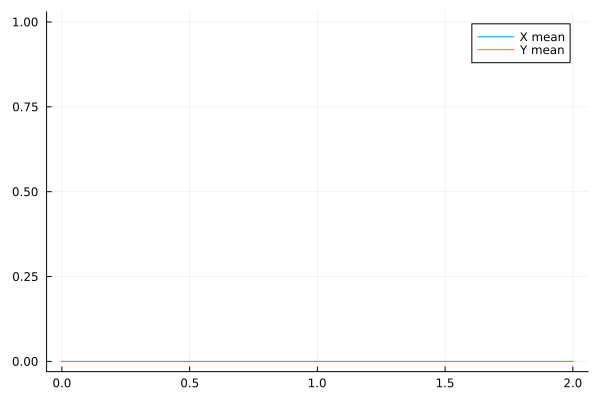

In [23]:
plot(tlist, X_mean_, label="X mean")
plot!(tlist, Y_mean_, label="Y mean")

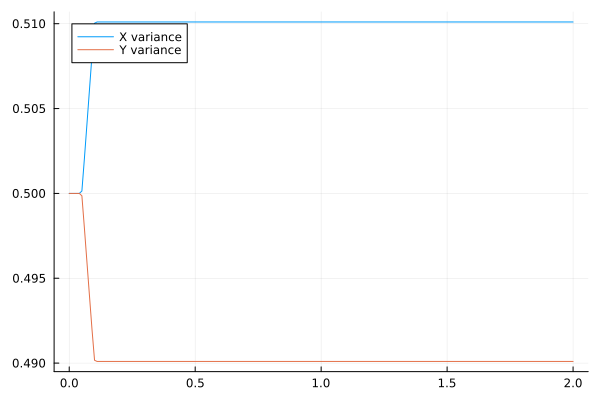

In [24]:
plot(tlist, X_var_, label="X variance")
plot!(tlist, Y_var_, label="Y variance")

In [25]:
u_first_ = sol_.u[1]
u_last_ = sol_.u[end]

Σ_first_ = covariance_matrix(u_first_)
Σ_last_ = covariance_matrix(u_last_)
μ_first_ = mean_quadrature(u_first_)
μ_last_ = mean_quadrature(u_last_);

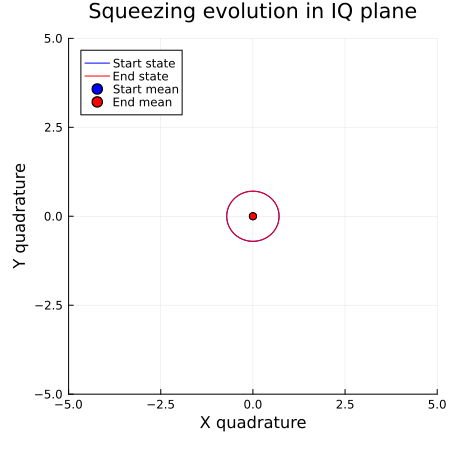

In [26]:
plot(size=(450, 450), legend=:topleft)
plot_cov_ellipse!(μ_first_, Σ_first_, color=:blue, label="Start state")
plot_cov_ellipse!(μ_last_, Σ_last_, color=:red, label="End state")
scatter!([μ_first_[1]], [μ_first_[2]], markershape=:circle, color=:blue, label="Start mean")
scatter!([μ_last_[1]], [μ_last_[2]], markershape=:circle, color=:red, label="End mean")
xlabel!("X quadrature")
ylabel!("Y quadrature")
title!("Squeezing evolution in IQ plane")
xlims!(-5, 5)
ylims!(-5, 5)
display(current());

Why no squeezing?

Want to add in decay now, then rebuild system and solve.

In [ ]:
@cnumbers γ


Now let's look at a system with 2 modes. Hamiltonian will include squeezing and conversion.

In [76]:
# Function definitions
function fisher_index(μ1, Σ1, μ2, Σ2)
    Sb = (μ1 - μ2)*(μ1 - μ2)'
    Sw = Σ1 + Σ2
    esys = eigen(Sb, Sw)
    w = esys.vectors[:,2]
    n = [0 1; -1 0]*w
    n = n/norm(n)
    J = esys.values[2]
    
    return J, w, n
end

function plot_states(μe, Σe, μg, Σg; lims=())
    J, w, n = fisher_index(μg, Σg, μe, Σe)

    p = covellipse(μe, Σe, n_std=2, aspect_ratio=:equal, label="e", legend=:topleft)
    covellipse!(μg, Σg, n_std=2, label="g", legend=:topleft)
    plot!([0, μe[1]], [0, μe[2]], arrow=false, label=false, color=:black, lw=2, aspect_ratio=:equal)
    plot!([0, μg[1]], [0, μg[2]], arrow=false, label=false, color=:black, lw=2, aspect_ratio=:equal)
    plot!([-norm(μe)*n[1], norm(μe)*n[1]], [-norm(μe)*n[2], norm(μe)*n[2]], label=false, color=:grey, ls=:dash, lw=2, aspect_ratio=:equal)
    
    # Paint a dashed circle around the origin with radius equal to abs2(μe)
    θ = range(0, stop=2π, length=100)
    x = norm(μe)*cos.(θ)
    y = norm(μe)*sin.(θ)
    plot!(x, y, label=false, color=:grey, ls=:dash, lw=2, aspect_ratio=:equal)
    if lims != ()
        xlims!(lims...)
        ylims!(lims...)
    end

    return p
end

plot_states (generic function with 1 method)

In [77]:
function plot_IQ_state(prob, ps; t_val, mode=:a, lims=nothing)
    # Set up ground and excited state parameters
    ps_g = ps
    ps_e = copy(ps_g)
    for (i, p) in enumerate(ps_e)
        if p.first === χ
            ps_e[i] = χ => -p.second
        end
    end

    # Solve for both states
    prob_g = remake(prob, p=ps_g)
    prob_e = remake(prob, p=ps_e)
    sol_g = solve(prob_g, Tsit5(), maxiters=1e7, saveat=[t_val], reltol=1e-10, abstol=1e-10)
    sol_e = solve(prob_e, Tsit5(), maxiters=1e7, saveat=[t_val], reltol=1e-10, abstol=1e-10)

    # Use the operator variables directly
    op = mode === :a ? a : mode === :s ? s : b
    op_dag = op'
    op_num = op'*op
    op_sq = op*op
    op_dag_sq = op'*op'

    # Compute moments
    moms_g = [sol_g[op][1], sol_g[op_dag][1], sol_g[op_num][1], sol_g[op_sq][1], sol_g[op_dag_sq][1]]
    moms_e = [sol_e[op][1], sol_e[op_dag][1], sol_e[op_num][1], sol_e[op_sq][1], sol_e[op_dag_sq][1]]
    Σg = covariance_matrix(moms_g)
    Σe = covariance_matrix(moms_e)
    μg = [real(sol_g[op][1]), imag(sol_g[op][1])]
    μe = [real(sol_e[op][1]), imag(sol_e[op][1])]

    # Set limits if not provided
    if lims === nothing
        # Compute ellipse radii for both states
        vals_e = eigvals(Σe)
        vals_g = eigvals(Σg)
        r_e = norm(μe) + 2 * sqrt(maximum(real(vals_e)))
        r_g = norm(μg) + 2 * sqrt(maximum(real(vals_g)))
        r = max(r_e, r_g)
        lims = (-r, r)
    end

    # Plot
    p = plot_states(μe, Σe, μg, Σg; lims=lims)
    title!("IQ state at t = $(t_val) μs (mode: $mode)")
    return p
end

plot_IQ_state (generic function with 1 method)

In [78]:
p_noaxes = plot_IQ_state(prob, ps; t_val=T0a_ + Ta_, mode=:a)
plot!(p_noaxes, legend=false, framestyle=:none, grid=false, background_color=:transparent, foreground_color_subplot=:transparent, axis=false, xticks=false, yticks=false)
p_noaxes
# Animate IQ evolution for readout mode (a) from t=0 to t=T0a_+Ta_ with fixed limits
# First, compute limits based on the final IQ state
final_t = T0a_ + Ta_
p_final = plot_IQ_state(prob, ps; t_val=final_t, mode=:a)
lims = xlims(p_final)  # Use the x-axis limits from the final state

tspan_anim = LinRange(0, final_t, 100)
anim = @animate for t_val in tspan_anim
    p = plot_IQ_state(prob, ps; t_val=t_val, mode=:a, lims=lims)
    title!("IQ evolution (a) at t = $(round(t_val, digits=3)) μs")
end

gif(anim, "IQ_readout_squeezing.gif", fps=20)

LoadError: UndefVarError: `χ` not defined

In [ ]:
function animate_IQ(prob, param_values, f1_, f2_, f3_, f4_, tlist; lims=[(-5, 5), (-5, 5), (-5, 5)])
    # Helper to extract parameter value by symbol
    function get_param(ps, sym)
        for p in ps
            if p.first === sym
                return p.second
            end
        end
        error("Parameter $sym not found")
    end

    # Remake the ODE problem for ground and excited state
    ps_g = param_values
    ps_e = copy(ps_g)
    for (i, p) in enumerate(ps_e)
        if p.first === χ
            ps_e[i] = χ => -p.second
        end
    end

    prob_g = remake(prob, p=ps_g)
    prob_e = remake(prob, p=ps_e)
    sol_g = solve(prob_g, Tsit5(), maxiters=1e7, saveat=tlist, reltol=1e-10, abstol=1e-10)
    sol_e = solve(prob_e, Tsit5(), maxiters=1e7, saveat=tlist, reltol=1e-10, abstol=1e-10)

    # Operator mapping
    ops = Dict(:a => a, :s => s, :b => b)

    # Helper to extract moments and covariances
    function get_moms_cov(sol, op)
        moms = [[sol[op][i], sol[op'][i], sol[op'*op][i], sol[op*op][i], sol[op'*op'][i]] for i in 1:length(sol.t)]
        covs = covariance_matrix.(moms)
        return moms, covs
    end

    moms_g, cov_g = Dict(), Dict()
    moms_e, cov_e = Dict(), Dict()
    for op in (:a, :s, :b)
        moms_g[op], cov_g[op] = get_moms_cov(sol_g, ops[op])
        moms_e[op], cov_e[op] = get_moms_cov(sol_e, ops[op])
    end

    na_g, ns_g, nb_g = real.(sol_g[a'*a]), real.(sol_g[s'*s]), real.(sol_g[b'*b])
    na_e, ns_e, nb_e = real.(sol_e[a'*a]), real.(sol_e[s'*s]), real.(sol_e[b'*b])

    # Compute Fisher Discriminant for each mode at each time
    fisher_a = [fisher_index(
        [real(sol_g[a][i]), imag(sol_g[a][i])], cov_g[:a][i],
        [real(sol_e[a][i]), imag(sol_e[a][i])], cov_e[:a][i]
    )[1] for i in 1:length(sol_g.t)]
    fisher_s = [fisher_index(
        [real(sol_g[s][i]), imag(sol_g[s][i])], cov_g[:s][i],
        [real(sol_e[s][i]), imag(sol_e[s][i])], cov_e[:s][i]
    )[1] for i in 1:length(sol_g.t)]
    fisher_b = [fisher_index(
        [real(sol_g[b][i]), imag(sol_g[b][i])], cov_g[:b][i],
        [real(sol_e[b][i]), imag(sol_e[b][i])], cov_e[:b][i]
    )[1] for i in 1:length(sol_g.t)]

    anim = @animate for i in 1:length(sol_g.t)
        # IQ plots for each mode
        μe_a = [real(sol_e[a][i]), imag(sol_e[a][i])]
        μg_a = [real(sol_g[a][i]), imag(sol_g[a][i])]
        Σe_a = cov_e[:a][i]
        Σg_a = cov_g[:a][i]
        p1 = plot_states(μe_a, Σe_a, μg_a, Σg_a; lims=lims[1])
        title!(p1, "Readout (a)")

        μe_s = [real(sol_e[s][i]), imag(sol_e[s][i])]
        μg_s = [real(sol_g[s][i]), imag(sol_g[s][i])]
        Σe_s = cov_e[:s][i]
        Σg_s = cov_g[:s][i]
        p2 = plot_states(μe_s, Σe_s, μg_s, Σg_s; lims=lims[2])
        title!(p2, "SNAIL (s)")

        μe_b = [real(sol_e[b][i]), imag(sol_e[b][i])]
        μg_b = [real(sol_g[b][i]), imag(sol_g[b][i])]
        Σe_b = cov_e[:b][i]
        Σg_b = cov_g[:b][i]
        p3 = plot_states(μe_b, Σe_b, μg_b, Σg_b; lims=lims[3])
        title!(p3, "Output (b)")

        p_top = plot(p1, p2, p3, layout=(1,3), size=(900, 300))

        # Overlay normalized pulse shapes for visibility
        max_n = maximum(vcat(na_g, ns_g, nb_g, na_e, ns_e, nb_e))

        # Fisher Discriminant plot (now second row)
        plot_fisher = plot(sol_g.t, fisher_a, label="Fisher (a)", lw=2, lc=:orange)
        plot!(sol_g.t, fisher_s, label="Fisher (s)", lw=2, lc=:purple)
        plot!(sol_g.t, fisher_b, label="Fisher (b)", lw=2, lc=:red)
        scatter!([sol_g.t[i]], [fisher_a[i]], label=false, color=:orange)
        scatter!([sol_g.t[i]], [fisher_s[i]], label=false, color=:purple)
        scatter!([sol_g.t[i]], [fisher_b[i]], label=false, color=:red)
        # Add pulse overlays to Fisher plot
        plot!(sol_g.t, max_n * f1_.(sol_g.t, get_param(ps_g, T0d), get_param(ps_g, Td)), fill=(0, :auto), fillalpha=0.1, label="Drive", lw=0, lc=:blue, ls=:dash)
        plot!(sol_g.t, max_n * f2_.(sol_g.t, get_param(ps_g, T0as), get_param(ps_g, Tas)), fill=(0, :auto), fillalpha=0.1, label="R-S conv", lw=0, lc=:green, ls=:dash)
        plot!(sol_g.t, max_n * f3_.(sol_g.t, get_param(ps_g, T0s), get_param(ps_g, Ts)), fill=(0, :auto), fillalpha=0.1, label="SNAIL sqz", lw=0, lc=:purple, ls=:dot)
        plot!(sol_g.t, max_n * f4_.(sol_g.t, get_param(ps_g, T0sb), get_param(ps_g, Tsb)), fill=(0, :auto), fillalpha=0.1, label="S-O conv", lw=0, lc=:red, ls=:dot)
        xlabel!("Time [μs]")
        ylabel!("Fisher Discriminant")

        # Photon number plot (now third row)
        plot_pulses = plot(sol_g.t, na_g, label="nₐ (g)", lw=2.5, lc=:orange)
        plot!(sol_g.t, ns_g, label=L"n_s (g)", lw=2.5, lc=:purple)
        plot!(sol_g.t, nb_g, label=L"n_b (g)", lw=2.5, lc=:red)
        plot!(sol_e.t, na_e, label=L"n_a (e)", lw=2.5, lc=:orange, ls=:dash)
        plot!(sol_e.t, ns_e, label=L"n_s (e)", lw=2.5, lc=:purple, ls=:dash)
        plot!(sol_e.t, nb_e, label=L"n_b (e)", lw=2.5, lc=:red, ls=:dash)
        plot!(sol_g.t, max_n * f1_.(sol_g.t, get_param(ps_g, T0d), get_param(ps_g, Td)), fill=(0, :auto), fillalpha=0.1, label="Drive", lw=0, lc=:blue, ls=:dash)
        plot!(sol_g.t, max_n * f2_.(sol_g.t, get_param(ps_g, T0as), get_param(ps_g, Tas)), fill=(0, :auto), fillalpha=0.1, label="R-S conv", lw=0, lc=:green, ls=:dash)
        plot!(sol_g.t, max_n * f3_.(sol_g.t, get_param(ps_g, T0s), get_param(ps_g, Ts)), fill=(0, :auto), fillalpha=0.1, label="SNAIL sqz", lw=0, lc=:purple, ls=:dot)
        plot!(sol_g.t, max_n * f4_.(sol_g.t, get_param(ps_g, T0sb), get_param(ps_g, Tsb)), fill=(0, :auto), fillalpha=0.1, label="S-O conv", lw=0, lc=:red, ls=:dot)
        scatter!([sol_g.t[i]], [na_g[i]], label=false, color=:orange)
        scatter!([sol_g.t[i]], [ns_g[i]], label=false, color=:purple)
        scatter!([sol_g.t[i]], [nb_g[i]], label=false, color=:red)
        scatter!([sol_e.t[i]], [na_e[i]], label=false, color=:orange, marker=:xcross)
        scatter!([sol_e.t[i]], [ns_e[i]], label=false, color=:purple, marker=:xcross)
        scatter!([sol_e.t[i]], [nb_e[i]], label=false, color=:red, marker=:xcross)
        xlabel!("Time [μs]")
        ylabel!("Photon number")

        plot(p_top, plot_fisher, plot_pulses, layout=(3,1), size=(900, 900))
    end

    return anim
end

In [ ]:
# Compute limits based on the IQ state at Td0_
p_final = plot_IQ_state(prob, ps; t_val=T0d_opt, mode=:a)
lims = xlims(p_final)

tspan_anim = LinRange(T0a_ + Ta_, T0d_opt, 80)
anim = @animate for t_val in tspan_anim
    p = plot_IQ_state(prob, ps; t_val=t_val, mode=:a, lims=lims)
    title!("IQ evolution (a) at t = $(round(t_val, digits=3)) μs")
end

gif(anim, "IQ_Ta_to_Td0.gif", fps=20)

In [ ]:
# Compute limits for each resonator based on the maximum photon number in each mode
max_a = sqrt(maximum(real.(sol_new[a'*a]))) * 1.2
max_s = sqrt(maximum(real.(sol_new[s'*s]))) * 1.2
max_b = sqrt(maximum(real.(sol_new[b'*b]))) * 1.2
lims = [(-max_a, max_a), (-max_s, max_s), (-max_b, max_b)]

# Plot the full animation of the sequence using animate_IQ and the parameters in ps
anim_full = animate_IQ(prob, ps, f1_, f2_, f3_, f4_, tlist; lims=lims)
gif(anim_full, "IQ_full_sequence.gif", fps=30)